In [95]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.layers import Dropout,Conv1D, MaxPooling1D,UpSampling1D

In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
# RANDOM_SEED = 42
# LABELS = ["Normal", "Fraud"]

In [3]:
#import data 
data = pd.read_csv("./moss_plos_one_data.csv")


In [4]:
all_data = data.drop(['Sgy', 'MET','eid','tte','death','direct','n_evts','LOS', 'ICU_Pt_Days', 'Mort', 'age', 'race', 'svc'], axis=1)


In [5]:
#take one row for every two rows for each patient
all_data["num"] = all_data.groupby("id").cumcount()
all_data = all_data[all_data.num % 2 == 0]
all_data.drop(["num"], axis=1,inplace=True)
all_data.shape


(1111009, 49)

In [44]:
all_data.columns

Index(['id', 'y', 'Glasgow.Coma.Scale.Total', 'O2.Flow', 'Resp', 'SpO2', 'SBP',
       'Pulse', 'Temp', 'ALBUMIN', 'ALKALINE.PHOSPHATASE', 'ALT.GPT',
       'AST.GOT', 'BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2',
       'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'LACTIC.ACID', 'MAGNESIUM',
       'OXYGEN.SATURATION', 'PARTIAL.THROMBOPLASTIN.TIME', 'PCO2',
       'PHOSPHORUS', 'PLATELET.COUNT', 'POTASSIUM', 'PROTIME.INR', 'SODIUM',
       'TOTAL.BILIRUBIN', 'TOTAL.PROTEIN', 'TROPONIN.I',
       'WHITE.BLOOD.CELL.COUNT', 'hr', 's2.hr', 's8.hr', 's24.hr', 'n.edrk',
       'edrk', 's2.edrk', 's8.edrk', 's24.edrk', 'srr', 'dfa', 'cosen', 'lds',
       'af', 'AF'],
      dtype='object')

In [6]:
#split data into 50% training and 50% test set 
id_list = list(set(all_data['id']))  # 8105
id_true = list(set(all_data[all_data['y'] == True].id))       # 367
id_false = [id for id in id_list if id not in id_true]
np.random.seed(10)
np.random.shuffle(id_false)
id_false_1 = id_false[0:4000]
id_false_2 = id_false[4000:6188]

id_true_1 = id_true[0:180]
id_true_2 = id_true[180:]




In [7]:
fasle_patient = all_data[all_data.y==False] #find non_event patients

true_patient =all_data[all_data.y==True]  #find patients with event


In [8]:

X_train = all_data[all_data.id.isin(id_false_1+id_true_1)]
x_test = all_data[all_data.id.isin(id_false_2+id_true_2)]


In [9]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
y_train = X_train.y
X_train = X_train.drop(['y',"id"], axis=1)
#SMOTE EVENT:NON-EVENT = 1:1
X_train = scaler.fit_transform(X_train)
sm = SMOTE(random_state=42)
new_X_train, new_y_train = sm.fit_sample(X_train, y_train)

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
y_test = x_test['y']
test_id = x_test["id"]

In [11]:
#Normalization
x_test = x_test.drop(['y',"id"], axis=1)
x_test = scaler.fit_transform(x_test)

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
#autoencoder with dropout regularization(0.5)
input_dim = new_X_train.shape[1]
encoding_dim = 30

input_layer = Input(shape=(input_dim, ))
encoder0 = Dropout(0.5)(input_layer)
encoder1 = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(encoder0)
encoder2 = Dense(int(encoding_dim / 2), activation="relu")(encoder1)
decoder0 = Dense(int(encoding_dim), activation='relu')(encoder2)
decoder1 = Dense(input_dim, activation='relu')(decoder0)
autoencoder = Model(inputs=input_layer, outputs=decoder1)


nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(new_X_train, new_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



Train on 1121630 samples, validate on 340207 samples
Epoch 1/20
1121630/1121630 [==============================] - 70s 62us/step - loss: 0.9229 - acc: 0.3144 - val_loss: 0.6967 - val_acc: 0.4198
Epoch 2/20
1121630/1121630 [==============================] - 69s 62us/step - loss: 0.8919 - acc: 0.3357 - val_loss: 0.6930 - val_acc: 0.4234
Epoch 3/20
1121630/1121630 [==============================] - 70s 62us/step - loss: 0.8883 - acc: 0.3399 - val_loss: 0.6926 - val_acc: 0.4310
Epoch 4/20
1121630/1121630 [==============================] - 69s 62us/step - loss: 0.8844 - acc: 0.3462 - val_loss: 0.6890 - val_acc: 0.4464
Epoch 5/20
1121630/1121630 [==============================] - 70s 62us/step - loss: 0.8825 - acc: 0.3474 - val_loss: 0.6920 - val_acc: 0.4269
Epoch 6/20
1121630/1121630 [==============================] - 69s 62us/step - loss: 0.8810 - acc: 0.3474 - val_loss: 0.6891 - val_acc: 0.4341
Epoch 7/20
1121630/1121630 [==============================] - 69s 62us/step - loss: 0.8807 - ac

In [14]:
autoencoder = load_model('model.h5')


In [26]:
enc = Model(inputs=input_layer, outputs=encoder2)

In [27]:
#create new features
new_feature = enc.predict(new_X_train)



In [28]:
#create a logistic regression using new features 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
model =clf.fit(new_feature,new_y_train)


/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
#create new features for test set
test_new_feature = enc.predict(x_test)


In [30]:
#predcit on the test set
pred = model.predict_proba(test_new_feature)


In [31]:
#find patients with event using the probability in top 1% predictions
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
y_test2 = np.array(y_test)
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

67

In [32]:
#calcualte ROC s
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6857513045589145

In [33]:
#misclassified non_event patients
len(list(set([i for i in test_id[ind] if i  in id_false])))

181

In [34]:
#total unique patients 
len(list(set(test_id[ind])))

248

In [35]:
len(list(set(test_id)))

2375

In [36]:
from sklearn import metrics
fp,t,thre= metrics.roc_curve(np.array(y_test), pred[:,1])

(0, 1)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


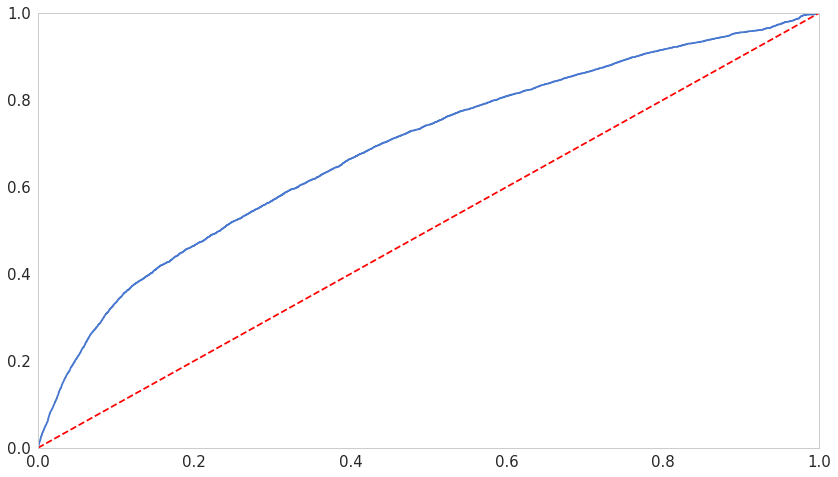

In [37]:
plt.plot(fp,t)
plt.grid("off")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])

In [39]:
patient5298 = test_new_feature[np.where(test_id ==5298)]


In [40]:
pred = model.predict_proba(patient5298)[:,1]


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


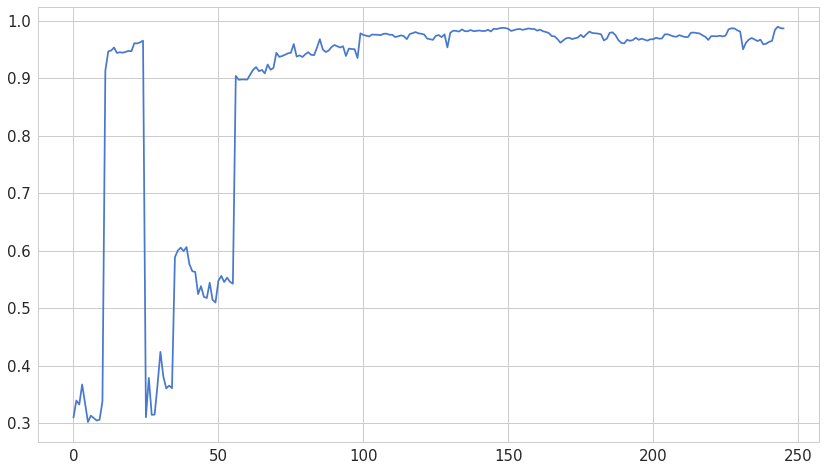

In [42]:
plt.plot(pred)
# z = [i*2/24 for i in np.arange(-len(pred)*30,0,30) if (i*2)%24==0]
# z

In [45]:
#concatenate new features with old features
col = ['Glasgow.Coma.Scale.Total', 'O2.Flow', 'Resp', 'SpO2', 'SBP',
       'Pulse', 'Temp', 'ALBUMIN', 'ALKALINE.PHOSPHATASE', 'ALT.GPT',
       'AST.GOT', 'BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2',
       'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'LACTIC.ACID', 'MAGNESIUM',
       'OXYGEN.SATURATION', 'PARTIAL.THROMBOPLASTIN.TIME', 'PCO2',
       'PHOSPHORUS', 'PLATELET.COUNT', 'POTASSIUM', 'PROTIME.INR', 'SODIUM',
       'TOTAL.BILIRUBIN', 'TOTAL.PROTEIN', 'TROPONIN.I',
       'WHITE.BLOOD.CELL.COUNT', 'hr', 's2.hr', 's8.hr', 's24.hr', 'n.edrk',
       'edrk', 's2.edrk', 's8.edrk', 's24.edrk', 'srr', 'dfa', 'cosen', 'lds',
       'af', 'AF']
train_combined = pd.concat([pd.DataFrame(new_X_train, columns=col),pd.DataFrame(new_feature)],axis=1)
test_combined = pd.concat([pd.DataFrame(x_test,columns=col),pd.DataFrame(test_new_feature)],axis=1)

In [46]:
#build a randomforest model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(train_combined, new_y_train)
new_pred = clf.predict_proba(test_combined)


In [48]:
ind = new_pred[:,1].argsort()[::-1][:round(len(new_pred)*0.01)]
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

57

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), new_pred[:,1])

0.46273502370633524

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


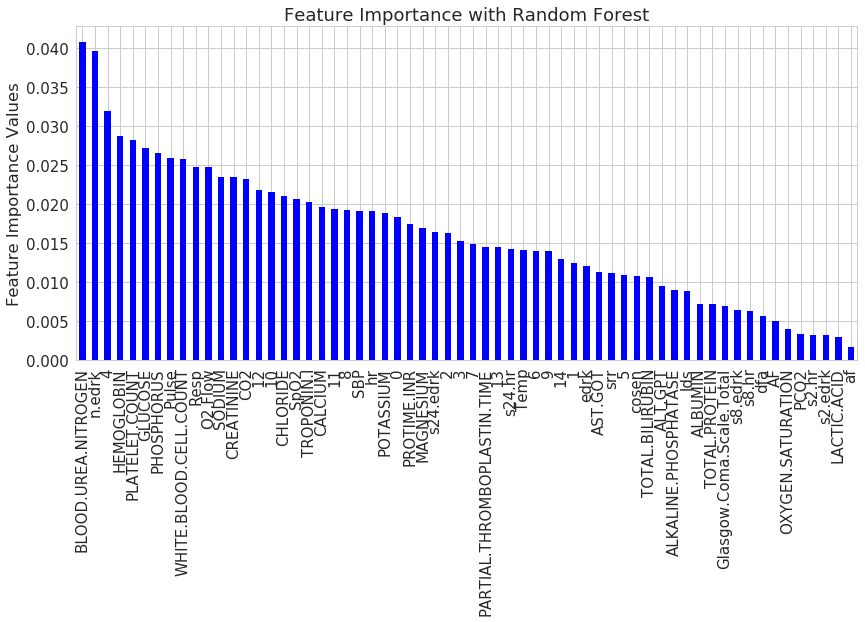

In [57]:
imp_feat_rf = pd.Series(clf.feature_importances_,index=train_combined.columns.tolist()).sort_values(ascending=False) 
imp_feat_rf.plot(kind='bar', title='Feature Importance with Random Forest', color='b', figsize=(14, 8))
plt.ylabel('Feature Importance Values')
plt.subplots_adjust(bottom=0.3)


In [78]:
#predct using top 20 features from the rf feature importance table
new_feature_1 = train_combined[imp_feat_rf[:20].index.tolist()]
new_test_feature_1 = test_combined[imp_feat_rf[:20].index.tolist()]
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
model =clf.fit(new_feature_1,new_y_train)
pred = model.predict_proba(new_test_feature_1)

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
#find patients with event
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

85

In [80]:
#ROC
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6961437703028398

In [81]:
#misclassified non_event patients
len(list(set([i for i in test_id[ind] if i  in id_false])))

225